# Iterative Approach for Unet Training 

------

## Overview



The purpose of this learn.ipynb notebook is to investigate whether an image can exhibit a preference for being segmented more effectively using a UNet model trained on polar or cartesian-dominant images.




-----


## File Structure
```
data
└── endoscopic
    ├── cartesian
    │   ├── image
    │   └── label
    └── polar
        ├── image
        └── label
```

Inside of each end folder there are 956 images, named as `0.tif` to `955.tif`
and I believe, for now, the naming of the images are one to one correctly matched, meaning the ``/data/endoscopic/**cartesian**/image/0.tif`` is transformed from `/data/endoscopic/**polar**/image/0.tif`

Instead of putting a seperate set of images aside to be test set, we chose to use k-fold cross validation.

In [1]:
from defines import *
from model import *
from data import *
import sys

from numpy import loadtxt
from keras.models import load_model
from PIL import Image

from sklearn.model_selection import KFold
from skimage.io import imread
from skimage import img_as_ubyte
from skimage.transform import resize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import math
import shutil

In [ ]:
# Import from files and libraries

In [2]:
#run this if your computer has a cuda visible device
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [ ]:
print(PARAM_SYSTEM_TIME)

In [ ]:
# Test code for correct file structure setup

In [ ]:
# Visualize folder tree in current directory
os.system("tree -d")

In [ ]:
#count of files in data directories
os.system("ls " + os.path.join(PARAM_PATH_CARTE,PARAM_IMG_FOLDER) + " | wc -l")
os.system("ls " + os.path.join(PARAM_PATH_CARTE,PARAM_MSK_FOLDER) + " | wc -l")
os.system("ls " + os.path.join(PARAM_PATH_POLAR,PARAM_IMG_FOLDER) + " | wc -l")
os.system("ls " + os.path.join(PARAM_PATH_POLAR,PARAM_MSK_FOLDER) + " | wc -l")


*Expected Output:
7404\
7404\
7404\
7404\
*

----

## File Relocation

In the following block, the code loads in one analysis file from previous research. 

### #File name postfix
_C_ is the dice scores of the predictions generated by Unet C: this Unet C is trained using all 7404 images, in their cartesian form. The raw image was directly input into the Unet and the prediction was generated.

_P_ is the dice scores of the predictions generated by Unet P: this Unet P is trained using all 7404 images but in their polar form. The raw images were transformed, and then input for prediction. The prediction is in polar space.

_P2C_ is the dice scores of the predictions generated by the same Unet P as mentioned above, but the dice score is generated by transforming the prediction back to cartesian, and compared to their original label.

In [3]:
#file_name = 'analysis_dice_back_Test_C.npy'
#file_name = 'analysis_dice_back_Test_P.npy'
#file_name = 'analysis_dice_back_Test_P2C.npy'
file_name = 'analysis_dice_back_Train_P.npy'

np_file = os.path.join(PARAM_PATH_SCORES, file_name)
#load npy file
img_score = np.load(np_file)

#sort scores in descending order and store index
sorted_score = np.flip(np.argsort(img_score))

#------DEBUG--------
#print(len(sorted_score))


The `sorted_score` should be a list of length 7404, sorted by the method we chose

In [ ]:
sorted_score = pd.DataFrame(sorted_score)

#fetch top polar dominant and non-polar dominant image
num_polar = round(len(sorted_score)/2)
num_cartesian = len(sorted_score) - num_polar
dfPolar = sorted_score.head(num_polar)
dfCartesian = sorted_score.tail(num_cartesian)
#print("Polar: \n", dfPolar)
#print("Cartesian: \n", dfCartesian)

Now in `dfPolar` should be the best half of images (filename), which performs better than the other half, according to the data we used above. In `dfCartesian` there's the other half.

In [ ]:
from filePrep import *

K = 5

checkNcreateTempFolder(PARAM_PATH_TEMP_POLAR, K)
checkNcreateTempFolder(PARAM_PATH_TEMP_CARTE, K)

The two lines creates the new temporary folder.
Instead of making kfolds later, the kfolds is assigned now.

In [ ]:
kf = KFold(n_splits = K, shuffle = True, random_state = 42) 

Use the KFold package to assign the paramters like n_splits and so.


In [ ]:
i = 0
for train_index,test_index in kf.split(dfPolar):
    fillFolder(test_index, dfPolar, PARAM_PATH_POLAR, PARAM_PATH_CARTE, PARAM_PATH_TEMP_POLAR, i)
    i += 1
i = 0
print('------------------------------------')
for train_index,test_index in kf.split(dfCartesian):
    fillFolder(test_index, dfCartesian, PARAM_PATH_POLAR, PARAM_PATH_CARTE, PARAM_PATH_TEMP_CARTE, i)
    i += 1

At this point we should have all `k-folds` set up. The next step is to write a training loop.


Due to the limitation of flow_from_directory, which, it does not allow the combination of multiple directories. And, the limitation of my knowledge of flow_from_dataframe. **I believe this is solvable using flow_from_dataframe** I decide to move training set into a separate temporary folder when training.

In [ ]:
batch_size = 4
PARAM_BETA_TEST_NUM = 6
data_gen_args = dict(rotation_range = 50,      # TODO: improve the data augmentation
                width_shift_range =0.2,
                height_shift_range =0.2,
                shear_range = 0.35,
                zoom_range = 0.05,
                horizontal_flip = True,
                fill_mode = 'nearest',
                rescale = 1./255)
#Train polar models
working_parent_folder = PARAM_PATH_TEMP_POLAR
Polar_history = []
for i in range(K):
    working_test_folder_i = os.path.join(working_parent_folder, str(i), PARAM_SUB_FOLDER_POLAR)
    temp_folder_path = os.path.join(working_parent_folder,'temp')
    os.mkdir(temp_folder_path)
    for j in range(K):
        if i != j:
            for subfolder_name in ['image','label']:
                subfolder_path = os.path.join(working_parent_folder,str(j),'polar',subfolder_name)
                temp_subfolder_path = os.path.join(temp_folder_path,subfolder_name)
                for root, dirs, files in os.walk(subfolder_path):
                    for file in files:
                        src_file = os.path.join(root, file)
                        dest_file = os.path.join(temp_subfolder_path,os.path.relpath(src_file, subfolder_path))
                        os.makedirs(os.path.dirname(dest_file), exist_ok=True)
                        shutil.copy(src_file, dest_file)
    test_gene = trainGenerator(batch_size, temp_folder_path, PARAM_IMG_FOLDER, PARAM_MSK_FOLDER, data_gen_args)
    model = unet(PARAM_BETA1[PARAM_BETA_TEST_NUM], PARAM_BETA2[PARAM_BETA_TEST_NUM]) 
    model_checkpoint = ModelCheckpoint(os.path.join(working_parent_folder,str(i),'checkpoint.hdf5'), monitor = 'loss', verbose=1, save_best_only=True)
    test_run = model.fit(test_gene, verbose = 1, steps_per_epoch = 100, epochs = 100, callbacks = [model_checkpoint])
    Polar_history.append(test_run)
    shutil.rmtree(temp_folder_path)
    
#Train cartesian models
data_gen_args = dict(rotation_range = 80,      # TODO: improve the data augmentation
                width_shift_range =0.02,
                height_shift_range =0.02,
                shear_range = 0.35,
                zoom_range = 0.075,
                horizontal_flip = True,
                fill_mode = 'nearest',
                rescale = 1./255)
working_parent_folder = PARAM_PATH_TEMP_CARTE
Cartesian_history = []
for i in range(K):
    working_test_folder_i = os.path.join(working_parent_folder, str(i), PARAM_SUB_FOLDER_CARTE)
    temp_folder_path = os.path.join(working_parent_folder,'temp')
    os.mkdir(temp_folder_path)
    for j in range(K):
        if i != j:
            for subfolder_name in ['image','label']:
                subfolder_path = os.path.join(working_parent_folder,str(j),'carte',subfolder_name)
                temp_subfolder_path = os.path.join(temp_folder_path,subfolder_name)
                for root, dirs, files in os.walk(subfolder_path):
                    for file in files:
                        src_file = os.path.join(root, file)
                        dest_file = os.path.join(temp_subfolder_path,os.path.relpath(src_file, subfolder_path))
                        os.makedirs(os.path.dirname(dest_file), exist_ok=True)
                        shutil.copy(src_file, dest_file)
    test_gene = trainGenerator(batch_size, temp_folder_path, PARAM_IMG_FOLDER, PARAM_MSK_FOLDER, data_gen_args)
    model = unet(PARAM_BETA1[PARAM_BETA_TEST_NUM], PARAM_BETA2[PARAM_BETA_TEST_NUM]) 
    model_checkpoint = ModelCheckpoint(os.path.join(working_parent_folder,str(i),'checkpoint.hdf5'), monitor = 'loss', verbose=1, save_best_only=True)
    test_run = model.fit(test_gene, verbose = 1, steps_per_epoch = 100, epochs = 100, callbacks = [model_checkpoint])
    Cartesian_history.append(test_run)
    shutil.rmtree(temp_folder_path)

In the last block there trained all 10 models, the 10 models' checkpoints are saved in the temp folder of each test model. For example, if stored in folder `temp/polar_Dom/0/`, the model is assumed to be trained on all folders except the current folder -- namingly, `folder 1,2,3,4`. 

In [ ]:
for single_run in Polar_history:
    plt.plot(single_run.history['loss'])
    plt.plot(single_run.history['accuracy'])
    plt.title('Polar Run')
    plt.xlabel('epoch')
    plt.legend(['loss', 'accuracy'], loc='upper left')
    plt.show()
print('________________________________________________')
for single_run in Cartesian_history:
    plt.plot(single_run.history['loss'])
    plt.plot(single_run.history['accuracy'])
    plt.title('Cartesian Run')
    plt.xlabel('epoch')
    plt.legend(['loss', 'accuracy'], loc='upper left')
    plt.show()

By now, all of the ten models from each group are trained, the next step is to load each of them and predict using every other images that are not in the training set as inputs. Note that `polar dominant models` should only take `polar` images as inputs and `cartesian dominant models` should only take `cartesian` images as inputs. 

This block is supposed to get and check the number of images and masks in the source folder. *could be moved to previous blocks*

In [4]:
#Predict using polar dominant images
image_extension = 'tif'
image_count = 0
img_pattern = os.path.join(PARAM_PATH_POLAR, PARAM_IMG_FOLDER, f'*.{image_extension}')
image_files = glob.glob(img_pattern)
msk_pattern = os.path.join(PARAM_PATH_POLAR, PARAM_MSK_FOLDER, f'*.{image_extension}')
msk_files = glob.glob(msk_pattern)
#length matching check
if len(image_files) == len(msk_files):
    print('WE have a matching number of images and labels here, count = ', len(msk_files))
else:
    print('Something is wrong with the original data set. [Unmatching number of images/masks.]')


WE have a matching number of images and labels here, count =  7404


In [5]:
K = 5 #if we don't want to train again, run this
PARAM_BETA_TEST_NUM = 6

In [6]:
# Create a numpy array to showcase the distribution of files

n = len(image_files)
m = K * 2

filematrix = np.zeros((n,m))
for img_type in ['polar', 'carte']:
    #
    img_extenstion = 'tif'
    #
    for_counter = 0
    if img_type == 'polar':
        working_parent_folder = PARAM_PATH_TEMP_POLAR
    else:
        working_parent_folder = PARAM_PATH_TEMP_CARTE
        for_counter += 1
    for i in range(K):
        image_path = os.path.join(working_parent_folder, str(i), img_type, PARAM_IMG_FOLDER)
        img_pattern = os.path.join(image_path, f'*.{image_extension}')
        image_files = glob.glob(img_pattern)
        for file_name in image_files:
            file_name_shorten = os.path.basename(file_name)
            file_name_raw, ext = os.path.splitext(file_name_shorten)
            filematrix[int(file_name_raw),i + for_counter * K] = 1
        number_of_ones = np.count_nonzero(filematrix == 1)
        #print(number_of_ones)  #uncomment this line when png file is not satisfactory, we can track the number of ones during each step  
plt.imsave('filematrix.png', filematrix, cmap = 'binary')
row_indices, col_indices = np.where(filematrix == 0)
indices = list(zip(row_indices, col_indices))

#### Here we will have a .png file saved to the root directory, zoom in and we should be able to see only one pixel is colored black in each row.
-------

In [23]:
def dice_coefficient(image1, image2):
    # Ensure the input images have the same shape
    if image1.shape != image2.shape:
        raise ValueError("Input images must have the same shape.")

    # Calculate the intersection (logical AND) between the two binary images
    intersection = np.logical_and(image1, image2).sum()

    # Calculate the sum of pixels in each image
    sum_image1 = image1.sum()
    sum_image2 = image2.sum()

    # Calculate the Dice coefficient
    dice = (2.0 * intersection) / (sum_image1 + sum_image2)

    return dice


In [8]:
import cv2

In the next block, we will loop through all sub folders, register all images appears in the training set, and reverse, and take the images from that specific big class, directly from the original data folder, and throw them to a temporary folder.

Now that we have the `filematrix`, we can go over each coloumn, pull out files into a temporary folder and make a round of prediction using that model if the value is 0.

In [33]:

scorematrix = np.zeros((n,m))
for img_type in ['polar', 'carte']:
    for_counter = 0
    if img_type == 'polar':
        working_parent_folder = PARAM_PATH_TEMP_POLAR
        src_folder = PARAM_PATH_POLAR
    else:
        working_parent_folder = PARAM_PATH_TEMP_CARTE
        src_folder = PARAM_PATH_CARTE
        for_counter += 1
    for i in range(K):
        current_folder_index = i + for_counter * K
        temp_test_folder_name = 'temptest'
        #print(working_parent_folder)
        if os.path.exists(temp_test_folder_name):
            shutil.rmtree(temp_test_folder_name)
        temp_test_img_folder = os.path.join(temp_test_folder_name,PARAM_IMG_FOLDER)
        temp_test_msk_folder = os.path.join(temp_test_folder_name,PARAM_MSK_FOLDER)
        os.makedirs(temp_test_img_folder)
        os.makedirs(temp_test_msk_folder)
        test_n_count = 0
        for indice in indices:
            if indice[1] == current_folder_index:
                test_n_count += 1
                img_name = str(indice[0]) + '.' + img_extenstion
                src = os.path.join(src_folder,PARAM_IMG_FOLDER,img_name)
                shutil.copy2(src, temp_test_img_folder)
                src = os.path.join(src_folder,PARAM_MSK_FOLDER,img_name)
                shutil.copy2(src, temp_test_msk_folder)
        
        model_path = os.path.join(working_parent_folder, str(i), 'checkpoint.hdf5')
        current_model = unet(PARAM_BETA1[PARAM_BETA_TEST_NUM], PARAM_BETA2[PARAM_BETA_TEST_NUM])
        current_model.load_weights(model_path) 
        for test_image_name in os.listdir(temp_test_img_folder):
            test_image_name_raw, ext = os.path.splitext(test_image_name)
            image_path = os.path.join(temp_test_img_folder, test_image_name)
            ground_truth_mask_path = os.path.join(temp_test_msk_folder, test_image_name)
            
            test_image = cv2.imread(image_path)
            test_image = cv2.cvtColor(test_image, cv2.COLOR_BGR2RGB)
            test_image = test_image / 255.0
            test_image = np.expand_dims(test_image,axis = 0)

            ground_truth_mask = cv2.imread(ground_truth_mask_path, cv2.IMREAD_GRAYSCALE)
            ground_truth_mask = ground_truth_mask / 255.0
            ground_truth_mask = ground_truth_mask.astype(np.uint8)
            
            prediction = current_model.predict(test_image, verbose = 0)
            
            threshold = 0.5
            binary_mask = (prediction > threshold).astype(np.uint8)
            binary_mask = binary_mask[0,:,:,0]
            dice = dice_coefficient(ground_truth_mask, binary_mask)
            scorematrix[int(test_image_name_raw), current_folder_index] = dice
        print('Done with folder ', current_folder_index)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


/home/panda/anaconda3/envs/unet/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


Done with folder  0
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Done with folder  1
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the T

Done with folder  9


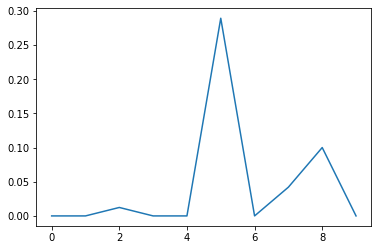

In [51]:
plt.plot(scorematrix[9,:])
plt.show()

### Cuiling's K-fold function

In [ ]:
#K fold Validation (obtain training & testing sets)
from sklearn.model_selection import KFold

kfold = KFold(n_splits=PARAM_SPLIT_NUM)
for train_index,test_index in kfold.split(dfPolar):
    polar_train,polar_test=dfPolar.iloc[train_index, :],dfPolar.iloc[test_index, :]
    cartesian_train,cartesian_test=dfCartesian.iloc[train_index, :],dfCartesian.iloc[test_index, :]
    #print("polar train: ", polar_train, "polar test: ", polar_test)
    #print("cartesian train" , cartesian_train, "cartesian test", cartesian_test)
    batch_size = 3
    PARAM_BETA_TEST_NUM = 6
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
    data_gen_args = dict(rotation_range = 80,      # TODO: improve the data augmentation
                width_shift_range =0.02,
                height_shift_range =0.02,
                shear_range = 0.35,
                zoom_range = 0.075,
                horizontal_flip = True,
                fill_mode = 'nearest',
                rescale = 1./255)
    print('-------------------------------------------------------------')
    test_model = unet(PARAM_BETA1[PARAM_BETA_TEST_NUM], PARAM_BETA2[PARAM_BETA_TEST_NUM]) 
    test_run = test_model.fit(polar_train, polar_test, verbose = 1, steps_per_epoch = 50, epochs = 5, callbacks = [early_stop])

-----

## Model training test

This part is used to see if we can train a model using the current configuration.

In [ ]:
# Setting Superparameters (temporary) for a test run of model training test

In [ ]:
batch_size = 4
PARAM_BETA_TEST_NUM = 6
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
data_gen_args = dict(rotation_range = 80,      # TODO: improve the data augmentation
                width_shift_range =0.02,
                height_shift_range =0.02,
                shear_range = 0.35,
                zoom_range = 0.075,
                horizontal_flip = True,
                fill_mode = 'nearest',
                rescale = 1./255)
test_gene = trainGenerator(batch_size, PARAM_PATH_CARTE, PARAM_IMG_FOLDER, PARAM_MSK_FOLDER, data_gen_args)
test_model = unet(PARAM_BETA1[PARAM_BETA_TEST_NUM], PARAM_BETA2[PARAM_BETA_TEST_NUM]) 
test_model.summary()

### Expected output
<details>
    <summary><b><font color="green">Click here to expand</font></b></summary>
    <code>
Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
==================================================================================================
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_120 (Conv2D)            (None, 256, 256, 64  1792        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_121 (Conv2D)            (None, 256, 256, 64  36928       ['conv2d_120[0][0]']             
                                )                                                                 
                                                                                                  
 max_pooling2d_20 (MaxPooling2D  (None, 128, 128, 64  0          ['conv2d_121[0][0]']             
 )                              )                                                                 
                                                                                                  
 conv2d_122 (Conv2D)            (None, 128, 128, 12  73856       ['max_pooling2d_20[0][0]']       
                                8)                                                                
                                                                                                  
 conv2d_123 (Conv2D)            (None, 128, 128, 12  147584      ['conv2d_122[0][0]']             
                                8)                                                                
                                                                                                  
 max_pooling2d_21 (MaxPooling2D  (None, 64, 64, 128)  0          ['conv2d_123[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_124 (Conv2D)            (None, 64, 64, 256)  295168      ['max_pooling2d_21[0][0]']       
                                                                                                  
 conv2d_125 (Conv2D)            (None, 64, 64, 256)  590080      ['conv2d_124[0][0]']             
                                                                                                  
 max_pooling2d_22 (MaxPooling2D  (None, 32, 32, 256)  0          ['conv2d_125[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_126 (Conv2D)            (None, 32, 32, 512)  1180160     ['max_pooling2d_22[0][0]']       
                                                                                                  
 conv2d_127 (Conv2D)            (None, 32, 32, 512)  2359808     ['conv2d_126[0][0]']             
                                                                                                  
 dropout_10 (Dropout)           (None, 32, 32, 512)  0           ['conv2d_127[0][0]']             
                                                                                                  
 max_pooling2d_23 (MaxPooling2D  (None, 16, 16, 512)  0          ['dropout_10[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_128 (Conv2D)            (None, 16, 16, 1024  4719616     ['max_pooling2d_23[0][0]']       
                                )                                                                 
                                                                                                  
 conv2d_129 (Conv2D)            (None, 16, 16, 1024  9438208     ['conv2d_128[0][0]']             
                                )                                                                 
                                                                                                  
 dropout_11 (Dropout)           (None, 16, 16, 1024  0           ['conv2d_129[0][0]']             
                                )                                                                 
                                                                                                  
 up_sampling2d_20 (UpSampling2D  (None, 32, 32, 1024  0          ['dropout_11[0][0]']             
 )                              )                                                                 
                                                                                                  
 conv2d_130 (Conv2D)            (None, 32, 32, 512)  2097664     ['up_sampling2d_20[0][0]']       
                                                                                                  
 concatenate_20 (Concatenate)   (None, 32, 32, 1024  0           ['dropout_10[0][0]',             
                                )                                 'conv2d_130[0][0]']             
                                                                                                  
 conv2d_131 (Conv2D)            (None, 32, 32, 512)  4719104     ['concatenate_20[0][0]']         
                                                                                                  
 conv2d_132 (Conv2D)            (None, 32, 32, 512)  2359808     ['conv2d_131[0][0]']             
                                                                                                  
 up_sampling2d_21 (UpSampling2D  (None, 64, 64, 512)  0          ['conv2d_132[0][0]']             
 )                                                                                                
                                                                                                  
 conv2d_133 (Conv2D)            (None, 64, 64, 256)  524544      ['up_sampling2d_21[0][0]']       
                                                                                                  
 concatenate_21 (Concatenate)   (None, 64, 64, 512)  0           ['conv2d_125[0][0]',             
                                                                  'conv2d_133[0][0]']             
                                                                                                  
 conv2d_134 (Conv2D)            (None, 64, 64, 256)  1179904     ['concatenate_21[0][0]']         
                                                                                                  
 conv2d_135 (Conv2D)            (None, 64, 64, 256)  590080      ['conv2d_134[0][0]']             
                                                                                                  
 up_sampling2d_22 (UpSampling2D  (None, 128, 128, 25  0          ['conv2d_135[0][0]']             
 )                              6)                                                                
                                                                                                  
 conv2d_136 (Conv2D)            (None, 128, 128, 12  131200      ['up_sampling2d_22[0][0]']       
                                8)                                                                
                                                                                                  
 concatenate_22 (Concatenate)   (None, 128, 128, 25  0           ['conv2d_123[0][0]',             
                                6)                                'conv2d_136[0][0]']             
                                                                                                  
 conv2d_137 (Conv2D)            (None, 128, 128, 12  295040      ['concatenate_22[0][0]']         
                                8)                                                                
                                                                                                  
 conv2d_138 (Conv2D)            (None, 128, 128, 12  147584      ['conv2d_137[0][0]']             
                                8)                                                                
                                                                                                  
 up_sampling2d_23 (UpSampling2D  (None, 256, 256, 12  0          ['conv2d_138[0][0]']             
 )                              8)                                                                
                                                                                                  
 conv2d_139 (Conv2D)            (None, 256, 256, 64  32832       ['up_sampling2d_23[0][0]']       
                                )                                                                 
                                                                                                  
 concatenate_23 (Concatenate)   (None, 256, 256, 12  0           ['conv2d_121[0][0]',             
                                8)                                'conv2d_139[0][0]']             
                                                                                                  
 conv2d_140 (Conv2D)            (None, 256, 256, 64  73792       ['concatenate_23[0][0]']         
                                )                                                                 
                                                                                                  
 conv2d_141 (Conv2D)            (None, 256, 256, 64  36928       ['conv2d_140[0][0]']             
                                )                                                                 
                                                                                                  
 conv2d_142 (Conv2D)            (None, 256, 256, 9)  5193        ['conv2d_141[0][0]']             
                                                                                                  
 conv2d_143 (Conv2D)            (None, 256, 256, 3)  30          ['conv2d_142[0][0]']             
                                                                                                  
==================================================================================================
Total params: 31,036,903
Trainable params: 31,036,903
Non-trainable params: 0
</code>
</details>    

In [ ]:
model_checkpoint = ModelCheckpoint('unet_endoscopic.hdf5', monitor = 'loss', verbose=1, save_best_only=True)

In [ ]:
for item1, item2 in test_gene:
    print(item1.shape)
    print(item2.shape)
    print('----------------')

In [ ]:
test_run = test_model.fit(test_gene, verbose = 1, steps_per_epoch = 100, epochs = 100, callbacks = [model_checkpoint])

In [ ]:
#print(test_run.history.keys())
plt.plot(test_run.history['loss'])
plt.plot(test_run.history['accuracy'])
plt.title('Test Run')
plt.xlabel('epoch')
plt.legend(['loss', 'accuracy'], loc='upper left')
plt.show()

In [ ]:
PARAM_PATH_TEST = './test'
image_name = '14.tif'
img = io.imread(os.path.join(PARAM_PATH_TEST,image_name),as_gray = False)
img = trans.resize(img,[256,256])
img = np.reshape(img,(1,)+img.shape)

results = test_model.predict(img,1,verbose=1)
#saveResult(Path,results)
img = results[0,:,:]
print(results.shape)
io.imsave(os.path.join(PARAM_PATH_TEST,"result.png"),img)

-----